In [1]:
%load_ext autoreload
%autoreload 2
import os
from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from animations.annimations_utils import *
from tqdm import tqdm

from bsccm import BSCCM
from encoding_information.datasets.bsccm_utils import *
from jax.scipy.stats import multivariate_normal
from tqdm import tqdm


2024-10-01 12:24:00.209335: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 12:24:02.883766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-01 12:24:02.884142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-01 12:24:02.884156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


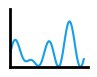

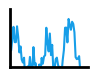

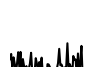

In [3]:
from signal_utils_1D import *

def plot_signal(signal):
    fig, ax = plt.subplots(1, 1, figsize=(1, .75))
    if not isinstance(signal, tuple) and not isinstance(signal, list):
        signal = (signal,)
        alpha = 1
    else:
        alpha = 0.75
    
    for s in signal:
        ax.plot(s, alpha=alpha) 
    clear_spines(ax)
    ax.set(xticks=[], yticks=[], xlim=[0, None], ylim=[0, 0.06])

def save(name, suffix='png'):
    if suffix == 'pdf':
        plt.savefig(f'/home/hpinkard_waller/figures/1d_conceptual/{name}.{suffix}', transparent=True)
    else:
        plt.savefig(f'/home/hpinkard_waller/figures/1d_conceptual/{name}.{suffix}', dpi=1200, transparent=True)

import os

def make_intermediate_directories(path):
    full_path = f'/home/hpinkard_waller/figures/1d_conceptual/{path}'
    os.makedirs(full_path, exist_ok=True)
    #clear all in dirs
    for f in os.listdir(full_path):
        os.remove(f'{full_path}/{f}')

# Parameters
upsampled_signal_length = 64
num_nyquist_samples = NUM_NYQUIST_SAMPLES        # Typically 8
noise_sigma = 0.01                           # Standard deviation of Gaussian noise

make_signal = lambda seed: onp.array(generate_random_signal(unit_energy=True, seed=seed, upsampled_signal_length=upsampled_signal_length, num_nyquist_samples=num_nyquist_samples))

def add_noise(signal, sigma, seed=None):
    if seed is not None:
        onp.random.seed(seed)
    return signal + onp.random.normal(0, noise_sigma, signal.shape)




seed = 42
signal = make_signal(seed)
noisy_signal = add_noise(signal, noise_sigma, seed=seed)

plot_signal(signal)
save('signal')
plot_signal(noisy_signal)
save('noisy_signal')

plot_signal(onp.random.normal(0, noise_sigma, signal.shape))
clear_spines(plt.gca(), 'all')
# change line color to black
plt.gca().get_lines()[0].set_color('black')
save('noise')


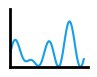

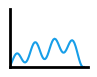

In [23]:

signal1 = make_signal(42)
signal2 = make_signal(43)

plot_signal(signal1)
save('signal1')

plot_signal(signal2)
# make it green
# plt.gca().get_lines()[0].set_color(get_color_cycle()[3])
save('signal2')


100%|██████████| 2000/2000 [00:03<00:00, 621.33it/s]


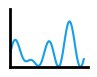

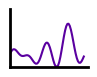

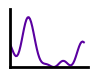

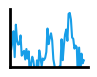

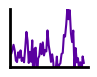

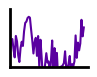

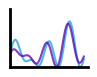

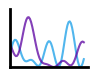

In [24]:
num_signals = 2000

ref_signal = make_signal(42)

test_signals = []
for i in tqdm(range(num_signals)):
    test_signals.append(make_signal(i))

test_signals = onp.stack(test_signals)

# compute MSE
mse = onp.mean((test_signals - ref_signal)**2, axis=1)
second_closest = np.argsort(mse)[2] # 0 is the reference signal
#find most dissimilar signal
furthest = np.argmax(mse)

plot_signal(ref_signal)
save('ref_signal')
plot_signal(test_signals[second_closest])
plt.gca().get_lines()[0].set_color(get_color_cycle()[1])
save('similar_to_ref_signal')
plot_signal(test_signals[furthest])
plt.gca().get_lines()[0].set_color(get_color_cycle()[1])
save('dissimilar_to_ref_signal')

# plot one noisy versions
plot_signal(add_noise(ref_signal, noise_sigma))
save('noisy_ref_signal')
plot_signal(add_noise(test_signals[second_closest], noise_sigma))
plt.gca().get_lines()[0].set_color(get_color_cycle()[1])
save('noisy_similar_to_ref_signal')
plot_signal(add_noise(test_signals[furthest], noise_sigma))
plt.gca().get_lines()[0].set_color(get_color_cycle()[1])
save('noisy_dissimilar_to_ref_signal')

plot_signal([ref_signal, test_signals[second_closest]])
save('ref_and_similar')

plot_signal([ref_signal, test_signals[furthest]])
save('ref_and_dissimilar')

In [21]:
# make 30 noisy realizations of the reference signal and the two test signals
num_frames = 30
noise_sigma = 0.01

noisy_ref_signals = []
noisy_similar_signals = []
noisy_dissimilar_signals = []

for i in range(num_frames):
    noisy_ref_signals.append(add_noise(ref_signal, noise_sigma))
    noisy_similar_signals.append(add_noise(test_signals[second_closest], noise_sigma))
    noisy_dissimilar_signals.append(add_noise(test_signals[furthest], noise_sigma))

make_intermediate_directories('noisy_ref_and_similar')
make_intermediate_directories('noisy_ref_and_dissimilar')

for i in tqdm(range(num_frames)):
    plot_signal([noisy_ref_signals[i], noisy_similar_signals[i]])
    save(f'noisy_ref_and_similar/{i}', 'png')
    plt.close()
    plot_signal([noisy_ref_signals[i], noisy_dissimilar_signals[i]])
    save(f'noisy_ref_and_dissimilar/{i}', 'png')
    plt.close()

!rm /home/hpinkard_waller/figures/1d_conceptual/noisy_ref_and_similar.mp4
!ffmpeg -y -framerate 15 -i /home/hpinkard_waller/figures/1d_conceptual/noisy_ref_and_similar/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/hpinkard_waller/figures/1d_conceptual/noisy_ref_and_similar.mp4

!rm /home/hpinkard_waller/figures/1d_conceptual/noisy_ref_and_dissimilar.mp4
!ffmpeg -y -framerate 15 -i /home/hpinkard_waller/figures/1d_conceptual/noisy_ref_and_dissimilar/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/hpinkard_waller/figures/1d_conceptual/noisy_ref_and_dissimilar.mp4

100%|██████████| 30/30 [00:04<00:00,  6.29it/s]


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

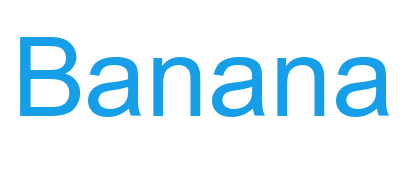

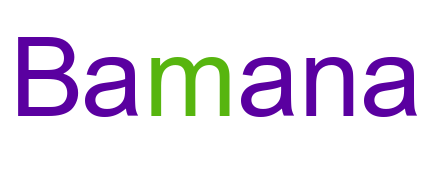

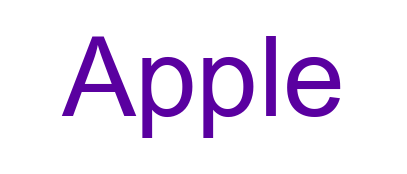

In [5]:
alpha = 0.05
num_frames = 30

def plot_banana_with_removed_letters(num=2, color=get_color_cycle()[0]):
    word = 'Banana'
    letters = list(word)
    num_letters = len(letters)
    
    x_positions = [0.1, 0.27, 0.43, 0.59, .75, .91]

    indices_to_remove = onp.random.choice(num_letters, num, replace=False)
    # indices_to_remove = []
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 2))
    
    # Plot each letter unless it's one of the randomly chosen ones
    for i, (x, letter) in enumerate(zip(x_positions, letters)):
        if i not in indices_to_remove:
            ax.text(x, 0.5, letter, fontsize=80, fontname='Arial',
                    ha='center', va='center', color=color)
        else:
            ax.text(x, 0.5, letter, fontsize=80, fontname='Arial',
                    ha='center', va='center', alpha=alpha, color=color)
    
    ax.axis('off')

    # now plot banaana not one letter at a time, in a different color
    # ax.text(0.5, 0.5, 'Banana', fontsize=80, fontname='Arial',
    #         ha='center', va='center', color='red')


def plot_bamana_with_removed_letters(num=2, color=get_color_cycle()[1]):
    word = 'Bamana'
    letters = list(word)
    num_letters = len(letters)
    
    x_positions = np.array([0.062, 0.23, 0.43, 0.632, .79, .95])

    indices_to_remove = onp.random.choice(num_letters, num, replace=False)
    # indices_to_remove = []
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 2))
    
    # Plot each letter unless it's one of the randomly chosen ones
    for i, (x, letter) in enumerate(zip(x_positions, letters)):
        if i not in indices_to_remove:
            ax.text(x, 0.5, letter, fontsize=80, fontname='Arial',
                    ha='center', va='center', color=color if i != 2 else get_color_cycle()[3])
        else:
            ax.text(x, 0.5, letter, fontsize=80, fontname='Arial',
                    ha='center', va='center', alpha=alpha, color=color if i != 2 else get_color_cycle()[3])
    
    ax.axis('off')

    # ax.text(0.5, 0.5, 'Bamana', fontsize=80, fontname='Arial',
    #         ha='center', va='center', color='red')



def plot_apple_with_removed_letters(num=2, color=get_color_cycle()[1]):
    word = 'Apple'
    letters = list(word)
    num_letters = len(letters)
    
    x_positions = np.array([0.227, 0.402, 0.56, 0.675, 0.785])

    indices_to_remove = onp.random.choice(num_letters, num, replace=False)
    # indices_to_remove = []
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 2))
    
    # Plot each letter unless it's one of the randomly chosen ones
    for i, (x, letter) in enumerate(zip(x_positions, letters)):
        if i not in indices_to_remove:
            ax.text(x, 0.5, letter, fontsize=80, fontname='Arial',
                    ha='center', va='center', color=color)
        else:
            ax.text(x, 0.5, letter, fontsize=80, fontname='Arial',
                    ha='center', va='center', alpha=alpha, color=color)
    
    ax.axis('off')

    # ax.text(0.5, 0.5, 'Apple', fontsize=80, fontname='Arial',
    #         ha='center', va='center', color='red')

# plot the full ones
plot_banana_with_removed_letters(0)
save(f'banana_full', 'png')
plot_bamana_with_removed_letters(0)
save(f'bamana_full', 'png')
plot_apple_with_removed_letters(0)
save(f'apple_full', 'png')
    

make_intermediate_directories('banana')
make_intermediate_directories('bamana')
make_intermediate_directories('apple')

for i in tqdm(range(num_frames)):
    plot_banana_with_removed_letters(2)
    save(f'banana/{i}', 'png')
    plt.close()
    plot_bamana_with_removed_letters(2)
    save(f'bamana/{i}', 'png')
    plt.close()
    plot_apple_with_removed_letters(2)
    save(f'apple/{i}', 'png')
    plt.close()


!rm /home/hpinkard_waller/figures/1d_conceptual/banana.mp4
!ffmpeg -y -framerate 15 -i /home/hpinkard_waller/figures/1d_conceptual/banana/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/hpinkard_waller/figures/1d_conceptual/banana.mp4

!rm /home/hpinkard_waller/figures/1d_conceptual/bamana.mp4
!ffmpeg -y -framerate 15 -i /home/hpinkard_waller/figures/1d_conceptual/bamana/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/hpinkard_waller/figures/1d_conceptual/bamana.mp4

!rm /home/hpinkard_waller/figures/1d_conceptual/apple.mp4
!ffmpeg -y -framerate 15 -i /home/hpinkard_waller/figures/1d_conceptual/apple/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/hpinkard_waller/figures/1d_conceptual/apple.mp4
